## Imports

In [1]:
## Uncomment only on colab
# !pip install transformers
# !git clone https://github.com/DanielSc4/Approach-LWD.git
# %cd Approach-LWD/src

In [3]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# from torch.utils.data import Dataset
from models.CustomDatasetBinary import CustomDatasetBinary
from torch.utils.data import DataLoader

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
### models_name = 'bert-base-uncased'

### BERT
# models_name = 'bert-base-uncased'
### RoBERTa
model_name = 'roberta-base'

In [5]:
# selecting device based on whats available
device = ''
if torch.cuda.is_available():
    print('Using GPU')
    device = 'cuda'
# Only on torch night for Apple M1 GPU
elif torch.backends.mps.is_available():
    print('Using MPS (Apple Silicon GPU)')
    device = 'mps'
else:
    print('Using CPU, :(')
    device = 'cpu'

Using MPS (Apple Silicon GPU)


## Datasets & loaders

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# starting w/ MD dataset
df = pd.read_csv('../data/MD_LoD.csv', index_col = 0)
df

# exclude labels == 2 (slightly agreement)
df = df[df['disagreement_lev'] != 2]
# shuffle dataser
df = df.sample(frac=1)


BATCH_SIZE = 20

train_set = CustomDatasetBinary(df[df['split'] == 'train'], tokenizer, label_col = 'disagreement_lev')
val_set = CustomDatasetBinary(df[df['split'] == 'dev'], tokenizer, label_col = 'disagreement_lev')
test_set = CustomDatasetBinary(df[df['split'] == 'test'], tokenizer, label_col = 'disagreement_lev')


# ############ only to overfit a batch (test to check model's correctness)
# fake_df = pd.concat(
#     [df[:BATCH_SIZE]] * 7   # concat the same batch multiple times
# )
# train_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# val_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# test_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# print(f'----------\n|-> Using fake_df: size {len(fake_df)}\n----------')
# ############ comment this section to train on the entire data available


print(f'len: \n\tTrain: {len(train_set)}\n\tVal: {len(val_set)}\n\tTest: {len(test_set)}')

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)

len: 
	Train: 4662
	Val: 787
	Test: 2148


## Model

In [7]:
from models.TransformerBinaryClassifier import TransformerBinaryClassifier

from transformers import AutoModel
transformer_model = AutoModel.from_pretrained(model_name, torch_dtype = torch.bfloat16)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
tokenizer(
    ['hello my name is Daniel', 'hello my name is Roberta'],
    padding = 'max_length', 
    max_length = 20, 
    truncation = True,
    return_tensors = "pt",
)

{'input_ids': tensor([[    0, 33600,    31,   759,  9351,    83, 11555,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0, 33600,    31,   759,  9351,    83, 12452,    11,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [8]:
# input of the model: 
#   input_ids
#   attention_mask
model = TransformerBinaryClassifier(
    model = transformer_model,
    dropout_rate = .2,
)
# inp, lbl = next(iter(train_loader))
# out = model(
#     inp['input_ids'],
#     inp['attention_mask'],
# )
# print(out.shape)
# out.reshape(len(out)).shape


In [9]:
from models.utils import train_loop
import torch.nn as nn

from torch.optim import Adam
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 4e-3)

history = train_loop(
    epochs = 5, 
    model = model, 
    device = device, 
    train_loader = train_loader, 
    val_loader = val_loader, 
    optimizer = optimizer, 
    criterion = criterion,
    log_freq = len(train_loader) // 10, 
    name = 'test1',
)

-- Epoch 01 --


TypeError: Trying to convert BFloat16 to the MPS backend but it does not have support for that dtype.

### Plot

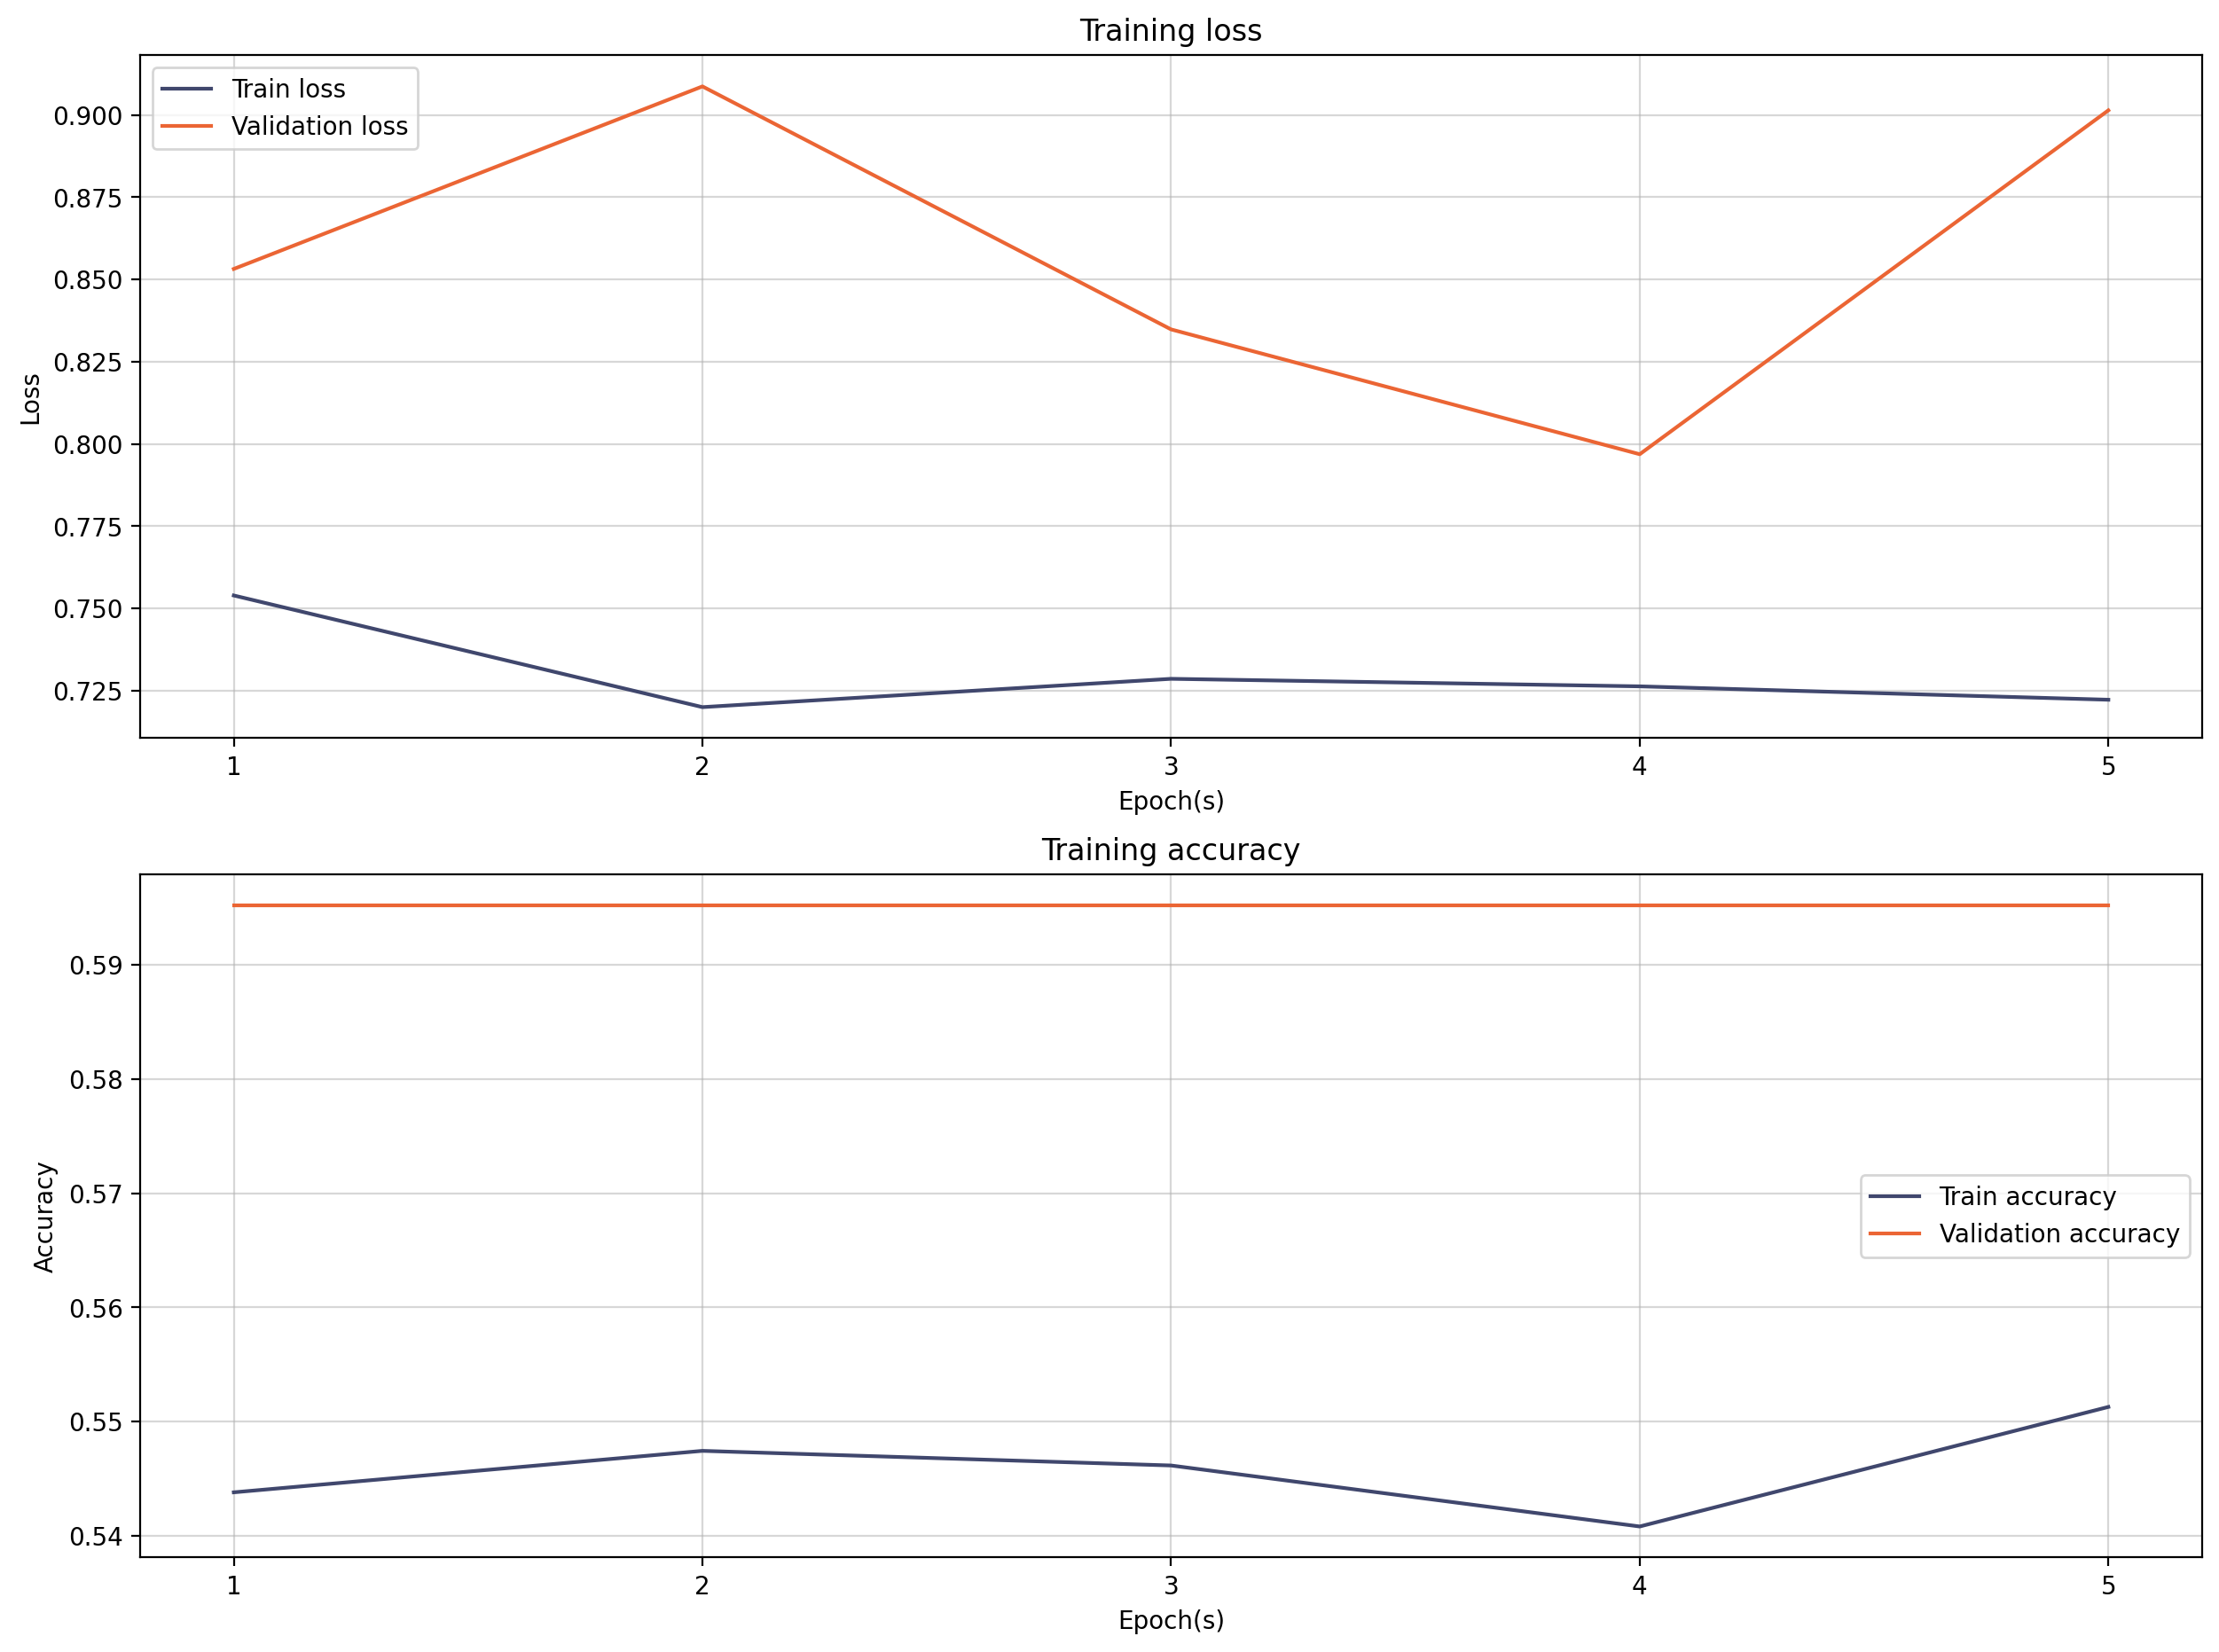

In [10]:
palette = {
    0: '#ACBEA3', 
    1: '#40476D', 
    2: '#826754', 
    3: '#EB6534',
    4: '#AD5D4E'
}
plt.figure(figsize= (15, 11), dpi = 200)

plt.subplot(2, 1, 1)
x = np.arange(len(history['train_losses'])) + 1
plt.xticks(x)
plt.plot(x, history['train_losses'], label = 'Train loss', color = palette[1])
plt.plot(x, history['val_losses'], label = 'Validation loss', color = palette[3])
plt.title('Training loss')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.grid(alpha = .5)
plt.legend()

plt.subplot(2, 1, 2)
plt.xticks(x)
plt.plot(x, history['train_accs'], label = 'Train accuracy', color = palette[1])
plt.plot(x, history['val_accs'], label = 'Validation accuracy', color = palette[3])
plt.title('Training accuracy')
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
plt.grid(alpha = .5)
plt.legend()

plt.show()

In [12]:
# tmp store
import pickle
with open('backup_history1.pkl', 'wb') as f:
    pickle.dump(history, f)

## Test

In [33]:
from models.utils import compute_acc

test_model = history['final_model'].to(device)

test_model.eval()
test_accs = .0

tot_outputs = []
tot_pred = []

for inputs, labels in test_loader:
    for ele in inputs:
            inputs[ele] = inputs[ele].to(device)
    labels = labels.to(device)
    with torch.no_grad():
          outputs = test_model(
                inputs['input_ids'],
                inputs['attention_mask'],
            ).reshape(len(labels))
    test_accs += compute_acc(outputs, labels)
    tot_outputs.extend([int(x) for x in outputs.round().flatten().tolist()])
    tot_pred.extend([int(x) for x in labels.round().flatten().tolist()])

print(f'Final accuracy: {test_accs / len(test_loader)}')

Final accuracy: 0.603009259259259


In [34]:
from sklearn.metrics import classification_report

print(classification_report(tot_outputs, tot_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75      2148
           1       0.00      0.00      0.00         0

    accuracy                           0.60      2148
   macro avg       0.50      0.30      0.38      2148
weighted avg       1.00      0.60      0.75      2148



/Users/daniel/miniforge3/envs/torch_new/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daniel/miniforge3/envs/torch_new/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daniel/miniforge3/envs/torch_new/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
